# Assignment 5

My data science team was asked by our stakeholders to implement a computer vision model which can properly classify handwritten numerical digits 0-9. To evaluate potential solutions my team focused on using Random Forest Classifiers and Principal Component Analysis (PCA) in concert with a Random Forest Classifier. For this application we do not recommend using PCA during deployment. My team found that PCA significantly increases the computational demand for this application by requiring additional computational resources to reduce the number of features in the training data and when fitting the reduced data set. Utilizing PCA increased the computation time by four times compared to simply scaling the data and then training a Random Forest Classifier. In addition to the increased computation time, the PCA Random Forest Classifier model had inferior predictive performance compared to the Random Forest Classifier. 

The initial phase of this work consisted of exploring the data to enhance our understanding of the machine learning inputs. This consisted of checking for any missing values, identifying the shape of the data, and gaining an understanding that the data consisted of 784 features. Each feature represented a single pixel in a 28 x 28 pixel image of a handwritten digit. A function was written to look at arbitrary rows from the dataset and displayed the handwritten image contained within. Summary statistics for arbitrary columns of features (pixels) were also examined. The team found that the pixel data had a range from 0 (white) to 255 (black). The data was then scaled using scikit learn’s MinMaxScaler in order to ensure all features ranged from 0-1 before fitting the machine learning models. To conduct our analysis, the team focused on two primary performance metrics. The first performance metric was the computational time it took to execute various pre-processing steps, feature reduction, and model fitting tasks. The second performance metric was the accuracy of our model when predicting labels from test data.

When 42,000 training instances were fed through a Pipeline to scale the data via the MinMaxScaler followed by training a Random Forest Classifier with 10 estimators it took approximately 2.5 seconds. The resultant model yielded an accuracy of 94.1%. When PCA was utilized, the team was able to reduce the number of features by over 80%, from 784 features to 154 features, while still maintaining 95% of the data variance. However, the PCA process required 4.8 seconds to complete. The resultant dataset output from the PCA step was then scaled and a Random Forest Classifier was fitted to the data. This step required another 4.9 seconds to complete. This PCA RF model was only able to achieve 88.2% accuracy when predicting the test data. In summary, using PCA required significant processing time to reduce the number of features and then increased the model fitting time of the Random Forest Classifier with no performance gain. As a result, our team does not recommend using PCA for this application. 

The data science team also conducted a more rigorous machine learning training-and-testing regimen by splitting off 20% of the initial training data into a validation and reduced training dataset. Cross validation techniques were utilized on the reduced training data and the validation dataset confirmed performance on an independent dataset for a fitted Random Forest Classifier. This approach increased our confidence in the performance of the Random Forest Classifier and its ability to generalize. This approach leveraged a variety of multi-class performance metrics such as F1_macro and ROC_AUC_OVR to expand the evaluation criteria of our machine vision model. Other multi-class classifiers were also trained and evaluated in a similar way to ensure the Random Forest Classifier was optimal for this application. When this model was submitted for scoring, it achieved 93.7% accuracy. The slight reduction in accuracy can be attributed to the smaller training set used to fit the classifier. This accuracy score was inline with all cross-validation accuracy metrics which increases our confidence in the ability of this model to scale predictably when deployed.

Lastly, the team explored KMeans clustering to determine how effective a semi-supervised approach would be for this application. KMeans found 10 clusters of data. For each cluster, a representative digit was sought to use as the digit label for each instance in that cluster. The KMeans algorithm identified 9 out of 10 unique digits. It was unable to identify 4, and over represented 1. After label propagation, a Random Forest Classifier was trained and tested yielding 0.0% accuracy. This occurred because the clustered labels only matched the actual training labels 58% of the time and omitted all predictions on 4. As a result, supervised learning will be required to deploy and maintain an effective machine vision solution.

# Load in packages and data:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  
import numpy as np               
import os
import pandas as pd  
import seaborn as sns 
import math
import sklearn
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
import re
from datetime import datetime
from sklearn.cluster import KMeans
import scikitplot as skplt

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Set seed:
seed = 42
set_fit_intercept = True

In [4]:
#Read in the data
mnist_train = pd.read_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/train.csv")
mnist_test = pd.read_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/test.csv")

# Start to explore the data

In [5]:
#Look at the head of the data:
mnist_train.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [6]:
#Look at an arbitrary pixel:
mnist_train['pixel350'].describe()

count    42000.000000
mean        89.505786
std        108.979799
min          0.000000
25%          0.000000
50%          0.000000
75%        228.000000
max        255.000000
Name: pixel350, dtype: float64

In [7]:
mnist_train.shape

(42000, 785)

So the training data is 42,000 images, there is a label column and then 784 pixel columns. Each image has 784 features (pixels). Each image is 28 x 28 pixels. Each feature represents one pixel's intensity from 0 (white) to 255 (black).

Let's take a look at one digit from the dataset. To do this, I will grab an instances feature vector and reshape it to a 28 x 28 array and display it:

In [8]:
#Define function to look at arbitrary handwritten digit for this data:

def image_show_train(row):
    some_digit = mnist_train.iloc[row]
    some_digit_image = np.array(some_digit[1:785]).reshape(28,28)
    plt.imshow(some_digit_image, cmap = "binary")
    plt.axis("off")
    plt.show()

In [9]:
image_show_train(23498)

I have looked at a couple of the handwritten images. They look very pixely. But it is clear that numbers can be read from them.

In [10]:
type(mnist_train['label'][0])

numpy.int64

Check to see what datatype the labels were in. The labels here are numeric. We do not want to feed a machine learning algorithm string labels.

In [11]:
mnist_test.shape

(28000, 784)

So training set has 42,000 images and test set has 28,000 images. This makes up a 60/40 split.

Just do another quick check to see if any data is missing from either the training or test set:

In [12]:
#Check the training set:
mnist_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [13]:
#Check test set:
mnist_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


Ok so no missing data indicated here. Looks like both training datasets and test datasets have images made up of 784 pixels (pixel0 - pixel783) and all the data is numeric (int64) type.

## (1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

In [14]:
#So first need to prepare the data by combining training and test data sets and scaling the data.
#Pixel digits are from 0 - 255. 
mnist_train_array = np.array(mnist_train.drop(labels = "label", axis = 1))
mnist_label_array = np.array(mnist_train['label'])
mnist_test_array = np.array(mnist_test)

In [15]:
#Stack the training and test data for one matrix of all handwritten images information:
mnist_all = np.vstack((mnist_train_array, mnist_test_array))
mnist_all.shape

(70000, 784)

In [16]:
#Create Pipeline anc RandomForestClassifier:
#Will use MinMaxScaler here to ensure data is between 0-1:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

rfclf = Pipeline([
    ('min_max', MinMaxScaler()),
    ('random_forest_classifier',RandomForestClassifier(n_estimators = 10, 
                                                       max_features = 'sqrt', 
                                                       bootstrap = True,
                                                       random_state = seed))
                     ], verbose = True)

#Based on assignment instructions:
#n_estimators = 10
#max_features = 'sqrt'
#bootstrap = True
#Be sure to set random_state so answer stays constant.


#Now fit the data:
start = datetime.now()
rfclf_784 = rfclf.fit(mnist_train_array,mnist_label_array)
#Requires y-label. This is still supervised learning!
end = datetime.now()
print("\n")
print("Time to train model: ", end-start)

#Now predict labels for test data:
part1_predictions = rfclf_784.predict(mnist_test_array)

[Pipeline] ........... (step 1 of 2) Processing min_max, total=   0.4s
[Pipeline]  (step 2 of 2) Processing random_forest_classifier, total=   2.0s


Time to train model:  0:00:02.397900


In [17]:
#Look at confusion matrix for the model:
#First need to get predictions based off the training dataset:
train_pred = rfclf_784.predict(mnist_train_array)

#Now look at confusion matrix for the training data set to review performance:
skplt.metrics.plot_confusion_matrix(train_pred, mnist_label_array, normalize = False)
plt.show()

Based on this confusion matrix, the Random Forest Classifier is a very strong performer! There are only a few instances where labels are not correctly predicted. The model appears to incorrectly guess labels 8 and 9 most frequently. 7 and 8 were the true labels incorrectly labeled the most. Overall each label has high precision.

However, this could easily be a case for overfitting the training data. We have not tested or validated this performance with any metrics on an independent data set. More to come on that as we will submit our data to Kaggle to understand the accuracy of our model on the test data set.

In [18]:
#Look at predictions array shape
part1_predictions.shape

(28000,)

In [19]:
#Create dataframe for exporting csv for Kaggle Entry:
part1_eval = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part1_predictions})

In [20]:
#Verify dataframe creation:
part1_eval.head()

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      7
4        5      3

In [21]:
#Export answers to csv and submit to Kaggle:
part1_eval.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part1_eval.csv", index = False)

#### Kaggle.com Score: 0.94092 UserID: MikeSoukup (ran on 2/10/2021 @ 9:55 PM CST)

### Because of Suspected Pipeline Issues, will try re-running out of Pipeline:

In [22]:
#First need to scale the data:
mn = MinMaxScaler()
mnist_train_minmax = mn.fit_transform(mnist_train_array)
mn = MinMaxScaler()
mnist_test_minmax = mn.fit_transform(mnist_test_array)

##Don't need to scale class labels!!

In [23]:
#Stack the training and test data for one matrix of all handwritten images information:
mnist_minmax = np.vstack((mnist_train_minmax, mnist_test_minmax))
mnist_all.shape

(70000, 784)

In [24]:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
start = datetime.now()
rfclf.fit(mnist_train_minmax,mnist_label_array)
end = datetime.now()
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train Random Forest Classifier on Full Data Set: ", end - start)
print("-------------------------------------------------------------------------------------------------------------")
part1_pred_nopipe = rfclf.predict(mnist_test_minmax)
#Create dataframe for exporting csv for Kaggle Entry:
part1_eval_nopipe = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part1_pred_nopipe})
part1_eval_nopipe.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part1_eval_nopipe.csv", index = False)

-------------------------------------------------------------------------------------------------------------
Time to train Random Forest Classifier on Full Data Set:  0:00:01.930409
-------------------------------------------------------------------------------------------------------------


#### Kaggle.com Score: 0.94092  UserID: MikeSoukup (ran on 2/13/2021 @ 9:27 AM CST)

In [25]:
a = part1_eval_nopipe == part1_eval
a.sum()

ImageId    28000
Label      28000
dtype: int64

Ok, so this quick test is re-assuring essentially telling us that both within and out of the Pipeline the same result was generated for all 28,000 test samples.

## (2) Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.

In [26]:
#Grab combined training and test data array:
mnist_all.shape

(70000, 784)

In [27]:
from sklearn.decomposition import PCA
#Remember that PCA automatically takes care of centering the data!

#To better understand the problem, I want to start by plotting Explained Variance vs. Dimensions:

pca = PCA()
pca.fit(mnist_all)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print("-------------------------------------------------------------------------------------------------------------")
print("\n")
print("{} principal components account for 95 percent of the variability in the MNIST dataset.".format(round(d)))
print("\n")
print("-------------------------------------------------------------------------------------------------------------")
plt.figure(figsize = (16,10))
plt.plot(cumsum, linewidth = 3)
plt.axis([0,784,0,1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([0,784],[0.95,0.95],"k:")
plt.plot([d,d],[0,0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.title("95% Explained Variance vs. Dimensions for MNIST PCA")
plt.show()

-------------------------------------------------------------------------------------------------------------


154 principal components account for 95 percent of the variability in the MNIST dataset.


-------------------------------------------------------------------------------------------------------------


The graph above shows that the majority of features included in the MNIST dataset provide very little value. Of the 784 features, only 154 are needed to make up 95% of the variability within the explanatory variables. PCA was utilized here as a reduction technique to help achieve this insight.

Going a bit further it looks like nearly 100% of the datasets variance can be explained with only 500 features. This means that nearly 35% of the original dataset provides absolutely no value in terms of aiding machine learning techniques in making predictions. 

In [28]:
#Now I will record the time it takes to generate the principal components:
start = datetime.now()
pca = PCA(n_components = 0.95)
mnist_reduced = pca.fit_transform(mnist_all)
end = datetime.now()
print("-------------------------------------------------------------------------------------------------------------")
print("Time to identify principal components accounting for 95% of MNIST data variance: ", end-start)
print("-------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------
Time to identify principal components accounting for 95% of MNIST data variance:  0:00:04.763865
-------------------------------------------------------------------------------------------------------------


In [29]:
#Check the effectiveness:
mnist_reduced.shape

(70000, 154)

Using PCA here to reduce the number of features was effective. The number of features was reduced from 784 to 154. This means the reduced data theoretically contains only 5% less information (data variance) but is 20% of the size of the original dataset. That seems like an outstanding tradeoff.

However, it did take a little over 5 seconds to perform PCA on the entire MNIST data set. It took only 2.5 seconds to train the Random Forest Classifier with the training MNIST dataset containing 42,000 rows. 

## (3) Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

In [30]:
#So training data is the first 42,000 rows of mnist_reduced. Strip those out and then re-run Random Forest Classifier:
mnist_train_red = mnist_reduced[:42000,:]
mnist_train_red.shape

(42000, 154)

In [31]:
#Must also isolate test data as well for executing preditions:
mnist_test_red = mnist_reduced[42000:,:]
mnist_test_red.shape

(28000, 154)

In [32]:
#Recall the Pipeline:
rfclf = Pipeline([
    ('min_max', MinMaxScaler()),
    ('random_forest_classifier',RandomForestClassifier(n_estimators = 10, 
                                                       max_features = 'sqrt', 
                                                       bootstrap = True,
                                                       random_state = seed))
                     ], verbose = True)

In [33]:
#Now fit the Random Forest Classifier to this reduced dataset and fit the data. Keeping track of time it takes:
start = datetime.now()
rfclf_red = rfclf.fit(mnist_train_red, mnist_label_array)
end1 = datetime.now()
part3_predictions = rfclf_red.predict(mnist_test_red)
end = datetime.now()
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train PCA reduced data Random Forest Classifier: ", end1 - start)
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train and predict PCA reduced data Random Forest Classifier: ", end - start)
print("-------------------------------------------------------------------------------------------------------------")

[Pipeline] ........... (step 1 of 2) Processing min_max, total=   0.0s
[Pipeline]  (step 2 of 2) Processing random_forest_classifier, total=   4.8s
-------------------------------------------------------------------------------------------------------------
Time to train PCA reduced data Random Forest Classifier:  0:00:04.869758
-------------------------------------------------------------------------------------------------------------
Time to train and predict PCA reduced data Random Forest Classifier:  0:00:04.925874
-------------------------------------------------------------------------------------------------------------


So interestingly, it actually took longer for the Random Forest Classifier to train and make predictions on the reduced data set. This seems counter intuitive, but that is what the results are showing. 

Based on the verbose output of the Pipeline, the preprocessing of the data via MinMax scalar was actually far quicker with the reduced data set. 0.1 s compared to 0.5 seconds for the full 784 feature training data set. But the training of the Random Forest Classifier is actually what took a longer time. Maybe because the reduced data set is more informationally dense?

In [34]:
#Look at the predictions:
part3_predictions.shape

(28000,)

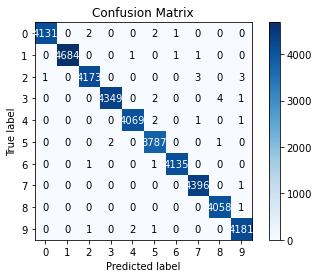

In [35]:
#Look at confusion matrix to get a sense of the performance of the model trained on the reduced dataset:
part3_train_pred = rfclf_red.predict(mnist_train_red)

#Now look at confusion matrix for the training data set to review performance:
skplt.metrics.plot_confusion_matrix(part3_train_pred, mnist_label_array, normalize = False)
plt.show()

This confusion matrix seems to indicate the the reduced dataset performs quite well on the training data. However, with how strongly the True Labels are matching the Predicted Labels, there is a strong case for overfitting the data here as well. 

In [36]:
#Create dataframe for exporting csv for Kaggle Entry:
part3_eval = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part3_predictions})
part3_eval.head()

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      2

In [37]:
#Compare part1 to part3 evaluations:
part1_vs_part3 = pd.DataFrame({"ImageId":list(range(1,28001)), "Part 1":part1_predictions, 
                               "Part 3":part3_predictions})


part1_vs_part3[part1_vs_part3["Part 1"] == part1_vs_part3["Part 3"]].describe()

ImageId        Part 1        Part 3
count  24551.000000  24551.000000  24551.000000
mean   13996.222598      4.284510      4.284510
std     8081.513424      2.891449      2.891449
min        1.000000      0.000000      0.000000
25%     7012.500000      2.000000      2.000000
50%    13963.000000      4.000000      4.000000
75%    21011.500000      7.000000      7.000000
max    28000.000000      9.000000      9.000000

So our labels from part 1 match our labels from part 3 24,551 or 87.7%, of the time. This is not great considering our part 1 answers were 94% accurate. However, we will test via Kaggle to see what the accuracy impact was with the part 3 labels produced with the reduced data frame.

In [38]:
#Export answers to csv and submit to Kaggle:
part3_eval.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part3_eval.csv", index = False)

#### Kaggle.com Score: 0.88239. User ID: MikeSoukup. ran on 2/11/2021 at 8:13PM CST

### Try doing this one outside of the Pipeline as well to verify results...

In [39]:
#First need to scale down the PCA reduced datasets:
mn = MinMaxScaler()
mnist_train_pca_mn = mn.fit_transform(mnist_train_red)
mn = MinMaxScaler()
mnist_test_pca_mn = mn.fit_transform(mnist_test_red)

print("Shape of PCA reduced scaled training data:", mnist_train_pca_mn.shape)
print("Shape of PCA reduced scaled test data:", mnist_test_pca_mn.shape)

Shape of PCA reduced scaled training data: (42000, 154)
Shape of PCA reduced scaled test data: (28000, 154)


In [40]:
#Now fit the Random Forest Classifier to this reduced dataset and fit the data. Keeping track of time it takes:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
start = datetime.now()
rfclf.fit(mnist_train_pca_mn,mnist_label_array)
part3_nopipe = rfclf.predict(mnist_test_pca_mn)
end = datetime.now()
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train and predict reduced data Random Forest Classifier: ", end - start)
print("-------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------
Time to train and predict reduced data Random Forest Classifier:  0:00:04.873374
-------------------------------------------------------------------------------------------------------------


In [41]:
#Create dataframe for exporting csv for Kaggle Entry:
part3_nopipe = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part3_nopipe})
part3_nopipe.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part3_eval_nopipe.csv", index = False)

#### Kaggle.com Score: 0.86725 UserId: MikeSoukup (ran on 2/13/2021 @ 9:38 AM CST)

Ok, so see here getting different results based on using the Pipeline vs. not using the Pipeline... will dig a little further..

In [42]:
b = part3_nopipe == part3_eval
b.sum()

ImageId    28000
Label      24572
dtype: int64

Ok, so here we are getting 87.7% match, nearly identical to the match error seen between the Part 1 and Part 3 eval above. There is something going on here that I am not seeing. 

In [43]:
c = part3_nopipe == part1_eval_nopipe
c.sum()

ImageId    28000
Label      24218
dtype: int64

Will continue to work out of the Pipeline and re-instantiate transformers and estimators as needed. I am not sure why I am getting some of the non-repeatable errors with the KMeans, but this type of flow is what I have more confidence with.

## (4) Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name.  I MUST have your user name to verify submission status.

#### RF Classifier - Kaggle.com Score: 0.94092 UserID: MikeSoukup (ran on 2/10/2021 @ 9:55 PM CST)

#### PCA RF Classifier - Kaggle.com Score: 0.88239. User ID: MikeSoukup (ran on 2/11/2021 @ 8:13PM CST)

## (5) The experiment we have proposed has a MAJOR design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. Provide your Kaggle.com score and user ID.

There are a couple of flaws with the current design that I can see:

1. We did not evaluate the performance of our model on our training data in anyway. We didn't learn how good our model was until we tested it by submitting to Kaggle.com. I believe the training data should be split into a validation training set in order to quantify the performance of our model.

2. In order to quantify the performance of our model, we need a multi-class classifier metric to compare performance. Accuracy is one, but may not tell the whole story especially if our data is unbalanced.

3. We only evaluated one multi-class classifier. We should evaluate several to determine how well different algorithms can perform in this situation.

In [44]:
#First split the training data into a training set and validation set:
X_train, X_val, y_train, y_val = train_test_split(mnist_train_minmax, mnist_label_array, 
                                                  test_size = 0.2, random_state = seed)

In [45]:
#Look at potential scoring options
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [46]:
#Check shape of the new training data set and validation data set:
print("New Trainind Data Shape: ", X_train.shape)
print("Validation Data Shape: ", X_val.shape)

New Trainind Data Shape:  (33600, 784)
Validation Data Shape:  (8400, 784)


In [47]:
#Now conduct cross-validation to determine the accuracy of the training model:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
#Use Accuracy, our classification is reasonably well balanced.
cross_val_score(rfclf, X_train, y_train, cv = 5, scoring = 'accuracy')

array([0.93497024, 0.93452381, 0.93348214, 0.93392857, 0.93630952])

Based on the accuracy metric, we can see that the Random Forest Classifier has a repeatedly high accuracy > 90% and generalizes well. Based on the evidence we found above, the model is overfitting the original training data, but the accuracy is still high when the model is evaluated on an independent dataset. 

In [48]:
#Now let's look at some other multi-class scoring methods:
#Now conduct cross-validation to determine the accuracy of the training model:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
#Use Accuracy, our classification is reasonably well balanced.
cross_val_score(rfclf, X_train, y_train, cv = 5, scoring = 'balanced_accuracy')

array([0.93409892, 0.93374367, 0.93267795, 0.93295428, 0.93545636])

The balanced accuracy score here is likely not much of a step up compared to accuracy in terms of information as our training set is relatively balanced already.

In [49]:
#Now let's look at some other multi-class scoring methods:
#Now conduct cross-validation to determine the accuracy of the training model:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
#Use Accuracy, our classification is reasonably well balanced.
cross_val_score(rfclf, X_train, y_train, cv = 5, scoring = 'f1_macro')

array([0.93400972, 0.93367622, 0.93259719, 0.93284197, 0.93541891])

In [50]:
#Now let's look at some other multi-class scoring methods:
#Now conduct cross-validation to determine the accuracy of the training model:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
#Use Accuracy, our classification is reasonably well balanced.
cross_val_score(rfclf, X_train, y_train, cv = 5, scoring = 'roc_auc_ovr')

array([0.99350657, 0.99261705, 0.99327962, 0.99221449, 0.99284866])

In [51]:
#Now let's look at some other multi-class scoring methods:
#Now conduct cross-validation to determine the accuracy of the training model:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
#Use Accuracy, our classification is reasonably well balanced.
cross_val_score(rfclf, X_train, y_train, cv = 5, scoring = 'roc_auc_ovo')

array([0.99344889, 0.9925563 , 0.99322219, 0.99215124, 0.99278652])

This model is clearly performing to high levels and generaling well regardless of the scoring metric.

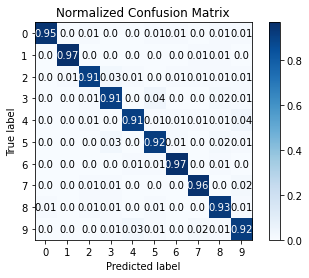

In [52]:
#So now let's try a cross_validated prediction approach:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
cv_pred = cross_val_predict(rfclf, X_train, y_train, cv = 5)
skplt.metrics.plot_confusion_matrix(cv_pred, y_train, normalize = True)
plt.show()

Cross_val_predict appears to overfit the data a lot less, I will compare to fitting the Random Forest Classifier on the training data and then trying to predict from the training data:

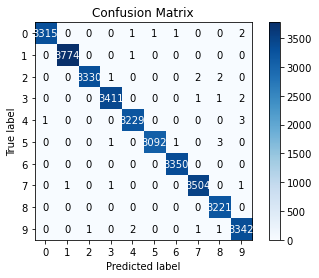

In [53]:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
rfclf.fit(X_train, y_train)
y_train_pred = rfclf.predict(X_train)
skplt.metrics.plot_confusion_matrix(y_train_pred, y_train, normalize = False)
plt.show()

So clearly without cross-validating the RF Classifier is overfitting the training data. Will confirm by looking at the performance on the validation set.

In [54]:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
rfclf.fit(X_train, y_train)
val_score = rfclf.score(X_val, y_val)
print("Random Forest Classifier Validation Data Score: ", round(val_score, 5))

Random Forest Classifier Validation Data Score:  0.93917


Now consider different multi-class Classification estimators:

In [55]:
from sklearn.svm import LinearSVC
SVCclf = LinearSVC(multi_class = "crammer_singer", verbose = 2)
SVCclf.fit(X_train, y_train)
val_score = SVCclf.score(X_val, y_val)
print("Linear SVC Validation Data Score: ", round(val_score, 5))

[LibLinear]Linear SVC Validation Data Score:  0.91583


In [56]:
from sklearn.linear_model import LogisticRegressionCV
LRclf = LogisticRegressionCV(multi_class = 'multinomial', verbose = 2, n_jobs = -1)
LRclf.fit(X_train, y_train)
val_score = LRclf.score(X_val, y_val)
print("Logistic Regression CV Data Score: ", round(val_score, 5))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Logistic Regression CV Data Score:  0.91964


Now the original training data has been split into a training data set and a validation data set. Multiple multi-classifiation metrics have been utilized along with cross-validation techniques to demonstrate the performance of the Random Forest Classifier model. We have found that the performance is quite high (> 90%) and generalizes well. We have also compared the Random Forest Classifier to other multi-class models like LinearSVC and LogisticRegressionCV and have shown that the Random Forest Classifier is superior compared to these other potential algorithms. 

The next step is to submit this model, now that its performance has been verified, to the test data and re-submit to Kaggle to see how it performs on the test.csv data.

In [57]:
#Re-train the model as a saftey check:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
rfclf.fit(X_train, y_train)

#Now make predictions on the test data:
part5_pred = rfclf.predict(mnist_test_minmax)

#Create dataframe and export to csv:
part5_eval = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part5_pred})
part5_eval.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part5_eval.csv", index = False)

#### Kaggle.com Score: 0.93682  UserId: MikeSoukup (ran on 2/13/2021 @ 7:53 PM CST)

The Kaggle.com Score took a slight hit here. This is likely due to the reduced training dataset. However, we took an improved approach to training and testing the model to give us confidence in the performance of this model. The Kaggle.com score was directly in line with our cross-validation accuracy scores confirming what we already noticed that this model fits the data to a high degree and generalizes well.

## (6)  Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels. Report total elapsed time measures for the training set analysis. 

In [58]:
#Set number of clusters:
k = 10

#Set up pipeline for KMeans

kmeans = Pipeline([('min_max', MinMaxScaler()),
                   ('KMeans', KMeans(n_clusters = k, random_state = seed))], verbose = True)

#Be sure to set random state in Kmeans!

#Fit and predict using the KMeans Pipeline:
train_pred = kmeans.fit_predict(mnist_train_array)

[Pipeline] ........... (step 1 of 2) Processing min_max, total=   0.4s
[Pipeline] ............ (step 2 of 2) Processing KMeans, total=   8.8s


In [59]:
#Need to find representative images for each cluster to properly label the clusters:
kmeans = KMeans(n_clusters = k, random_state = seed)
X_digits_dist = kmeans.fit_transform(mnist_train_array)
representative_digit_idx = np.argmin(X_digits_dist, axis = 0)
X_representative_digits = mnist_train_array[representative_digit_idx]

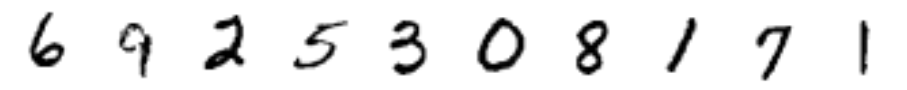

In [60]:
#Now need to look at each representative image and label it:
plt.figure(figsize = (16,6))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(28,28), cmap = 'binary', interpolation = 'bilinear')
    plt.axis('off')

plt.show()

From the KMeans algorithm it looks like we were able to cluster the training data pretty well. 9 of the 10 unique digits were picked out. However, there was no good cluster for the number 4. The 1 digit was represented twice. This will likely lead to errors moving forward by using these representative images as the labels for each instance in the cluster as 4 will likely be under represented.

Have to be sure to set the random_state in the kmeans, otherwise will get different answers everytime it is ran!

In [61]:
#Get an idea of how much potential error there will be by looking at the number of 4's actually present
#in the training dataset:
mnist_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

So 4 is the third fewest instance count represented in the training dataset while 1 is the highest. The similarity between the two digits and the higher prevelance of 1s may be what attributed to two clusters closely resembling 1 instead of 4.

In [62]:
#Translate the representative image labels identified above to y-array.
y_representative_digits = np.array([6,9,2,5,3,0,8,1,7,1])

In [63]:
#Now conduct label propagation:
y_train_propagated = np.empty(len(mnist_train_array))

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [64]:
### Now that all the code is written out, conduct the time trial ###

#Need to find representative images for each cluster to properly label the clusters:
start = datetime.now()

kmeans = KMeans(n_clusters = k, random_state = seed) #Be sure to set random_state!!!
X_digits_dist = kmeans.fit_transform(mnist_train_array)
representative_digit_idx = np.argmin(X_digits_dist, axis = 0)
X_representative_digits = mnist_train_array[representative_digit_idx]

#Create cluster labels from images:
y_representative_digits = np.array([6,9,2,5,3,0,8,1,7,1])

#Now conduct label propagation:
y_train_propagated = np.empty(len(mnist_train_array))

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

end = datetime.now()

print("Shape of new labels array based off clusters:", y_train_propagated.shape)
print("\n")
print("-------------------------------------------------------------------------------------------------------------")
print("Total elapsed time to group MNIST training data into 1 of 10 categories and assign labels: ", end-start)
print("-------------------------------------------------------------------------------------------------------------")

Shape of new labels array based off clusters: (42000,)


-------------------------------------------------------------------------------------------------------------
Total elapsed time to group MNIST training data into 1 of 10 categories and assign labels:  0:00:08.867784
-------------------------------------------------------------------------------------------------------------


In [65]:
#Now let's check the running performance of the RF classifier with these new labels on the Random Forest Classifer
#And on the PCA Random Forest Classifier:

start = datetime.now()
rf_lp_784 = rfclf.fit(mnist_train_array,y_train_propagated)
rf_lp_testpred = rf_lp_784.predict(mnist_test_array)
end = datetime.now()
print("Number of features rf_lp_784:", rf_lp_784.n_features_)
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train and predict label propagated Full Random Forest Classifier: ", end - start)
print("-------------------------------------------------------------------------------------------------------------")

start = datetime.now()
rf_lp_pca = rfclf.fit(mnist_train_red, y_train_propagated)
rf_lp_pcatestpred = rf_lp_pca.predict(mnist_test_red)
end = datetime.now()
print("Number of features rf_lp_pca:", rf_lp_pca.n_features_)
print("-------------------------------------------------------------------------------------------------------------")
print("Time to train and predict label propagated PCA Random Forest Classifier: ", end - start)
print("-------------------------------------------------------------------------------------------------------------")

Number of features rf_lp_784: 784
-------------------------------------------------------------------------------------------------------------
Time to train and predict label propagated Full Random Forest Classifier:  0:00:02.015212
-------------------------------------------------------------------------------------------------------------
Number of features rf_lp_pca: 154
-------------------------------------------------------------------------------------------------------------
Time to train and predict label propagated PCA Random Forest Classifier:  0:00:04.830873
-------------------------------------------------------------------------------------------------------------


In [66]:
#Let's also look at some cross-validation performance of both these models as well:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
rf_lp_784_accuracyscores = cross_val_score(rfclf, mnist_train_array, y_train_propagated)
rf_lp_pca_accuracyscores = cross_val_score(rfclf, mnist_train_red, y_train_propagated)

print("-------------------------------------------------------------------------------------------------------------")
print("Cross-validated accuracy scores for Full Data Set after Label Propagation: \n")
print(rf_lp_784_accuracyscores)
print("Average cross-validated accuracy score: ", round(rf_lp_784_accuracyscores.mean(),4))
print("-------------------------------------------------------------------------------------------------------------")
print("Cross-validated accuracy scores for PCA Data Set after Label Propagation: \n")
print(rf_lp_pca_accuracyscores)
print("Average cross-validated accuracy score: ", round(rf_lp_pca_accuracyscores.mean(),4))
print("-------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------
Cross-validated accuracy scores for Full Data Set after Label Propagation: 

[0.89583333 0.89857143 0.89       0.89238095 0.88988095]
Average cross-validated accuracy score:  0.8933
-------------------------------------------------------------------------------------------------------------
Cross-validated accuracy scores for PCA Data Set after Label Propagation: 

[0.8675     0.86011905 0.85678571 0.86654762 0.86059524]
Average cross-validated accuracy score:  0.8623
-------------------------------------------------------------------------------------------------------------


This shows that with label propagation, the performance of the Random Forest Classifier decreases, however it still generalizes relativel well. The performance gap between the PCA data and Full Data Set is not too drastic. Only dropping by 3%.

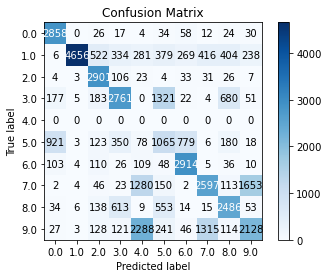

In [67]:
#Look at performance of the two different methods via Confusion Matrices:
#First consider the Full Data Set:
#Having issues so will try recalling...
rf_lp_784 = rfclf.fit(mnist_train_array,y_train_propagated)
rf_lp_784_trainpred = rf_lp_784.predict(mnist_train_array)
skplt.metrics.plot_confusion_matrix(rf_lp_784_trainpred, mnist_label_array, normalize = False)
plt.show()

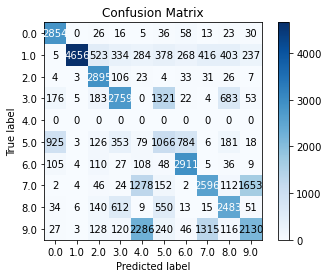

In [68]:
#Now consider the PCA Data Set:
rf_lp_pca_trainpred = rf_lp_pca.predict(mnist_train_red)
skplt.metrics.plot_confusion_matrix(rf_lp_pca_trainpred, mnist_label_array, normalize = False)
plt.show()

Clearly we can see that with both of these new models, the KMeans cluster will fail us in that there will be no 4 digits predicted. But also 1 is over representing the predictions. The predictive ability of these two models is clearly deteriorated by employing the semi-supervised learning methods. This helps show the power of supervised learning vs. unsupervised / semi-supervised techniques. 

In [69]:
#Now let's re-run both of these through Kaggle just to see what Scores would be generated:
#Start with Full Model:
#Create dataframe for exporting csv for Kaggle Entry:
part6_full = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":rf_lp_testpred})
part6_full.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part6_full.csv", index = False)

#Now look at PCA model:
part6_pca = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":rf_lp_pcatestpred})
part6_full.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part6_pca.csv", index = False)

#### Semi-Supervised Label Propagation with Full MNIST Data Set. Kaggle.com Score:  0.0000    UserId: MikeSoukup (ran @  9:08 2/13/2021 CST)

#### Semi-Supervised Label Propagation with PCA MNIST Data Set. Kaggle.com Score: 0.0000   UserId: MikeSoukup (ran @ 9:10 2/13/2021 CST)

### Try running this one out of the Pipeline...

In [70]:
#Need to find representative images for each cluster to properly label the clusters:
kmeans = KMeans(n_clusters = k, random_state = seed)
X_digits_dist = kmeans.fit_transform(mnist_train_minmax)
representative_digit_idx = np.argmin(X_digits_dist, axis = 0)
X_representative_digits = mnist_train_minmax[representative_digit_idx]

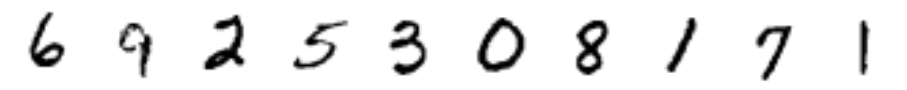

In [71]:
#Now need to look at each representative image and label it:
plt.figure(figsize = (16,6))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(28,28), cmap = 'binary', interpolation = 'bilinear')
    plt.axis('off')

plt.show()

Ok good, this is repeatable...

In [72]:
#Translate the representative image labels identified above to y-array.
y_representative_digits = np.array([6,9,2,5,3,0,8,1,7,1])

In [73]:
#Now conduct label propagation:
y_train_propagated = np.empty(len(mnist_train_minmax))

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [74]:
y_train_propagated.shape

(42000,)

In [75]:
mnist_label_array.shape

(42000,)

In [76]:
#Check for equivalency between these two arrays...
y_train_prop = pd.DataFrame({"ImageId":list(range(1,42001)), "Label":y_train_propagated})
mnist_true_label =  pd.DataFrame({"ImageId":list(range(1,42001)), "Label":mnist_label_array})

In [77]:
check = y_train_prop == mnist_true_label

In [78]:
check.sum()

ImageId    42000
Label      24348
dtype: int64

The propagated labels only match the true labels around 58% of the time. This will certainly help explain WHY the models created with the propagated labels perform poorly. However, I still do not suspect that they should have a test Accuracy of 0. So I will re-confirm this by re-conducting testing and Kaggle Evaluation out of the Pipeline.

In [79]:
rfclf = RandomForestClassifier(n_estimators = 10,max_features = 'sqrt',bootstrap = True,random_state = seed)
rfclf.fit(mnist_train_minmax, y_train_propagated)
part6_nopipe_pred = rfclf.predict(mnist_test_minmax)
part6_nopipe = pd.DataFrame({"ImageId":list(range(1,28001)), "Label":part6_nopipe_pred})
part6_nopipe.to_csv("/Users/mikesoukup/Desktop/NU MSDS/MSDS 422/Module 5/assignment5_part6_full_nopipe.csv", index = False)

So I resubmitted under new UserName: MikeySoukup and re-confirmed that the Accuracy score was 0. So it doesn't look like Pipelines were the issue here. But rather, Semi-Supervised clustering and label propagation techniques are vastly inferior to Supervised learning techniques... Even when the Semi-supervised learning label propagation can get the labels right over half the time in a multi-class situation.

# Having a bunch of issues, will try re-conducting work without Pipeline. It seems that answers are carrying over. Think it is a Pipeline issue...